In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../data_segments/chrc_data_segments/"
sz=256

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['train', 'valid', 'tmp', 'models']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C11-54_02_7326_18981.jpg',
 'C11-55_01_8500_4500.jpg',
 'C14-71_01_3330_2331.jpg',
 'C10-51_02_9657_3330.jpg',
 'C11-55_01_4329_1332.jpg']

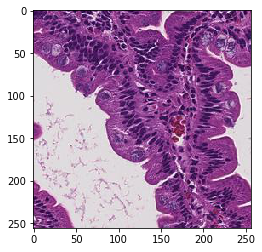

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[0]}')
plt.imshow(img);

In [9]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
learn.fit(0.001, 4)

epoch      trn_loss   val_loss   accuracy                      
    0      0.323073   0.217701   0.894716  
    1      0.292728   0.207495   0.897981                      
    2      0.289417   0.200964   0.901609                      
    3      0.284353   0.201095   0.901221                      


[array([0.20109]), 0.9012207849073233]

## Visualising Results

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 2, 2, 2])

In [15]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

['Celiac', 'EE', 'Normal']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(82406, 3)

Most Correct Celiac


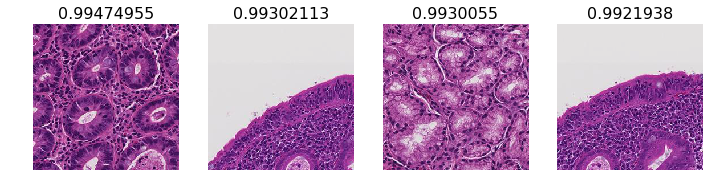

In [17]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

Most Correct EE


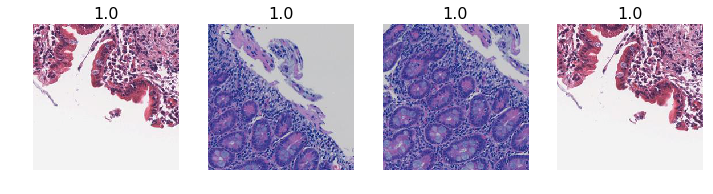

In [18]:
print('Most Correct EE')
imr.plot_most_correct(1)

Most Correct Normal


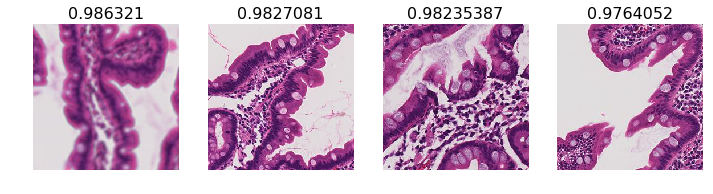

In [19]:
print('Most Correct Normal')
imr.plot_most_correct(2)

Most Incorrect Celiac


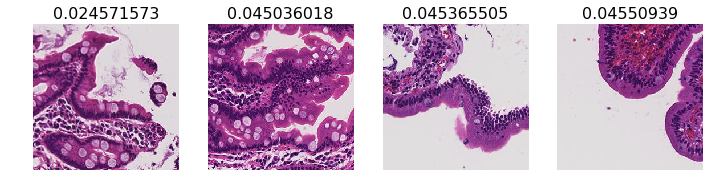

In [20]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

Most Incorrect EE


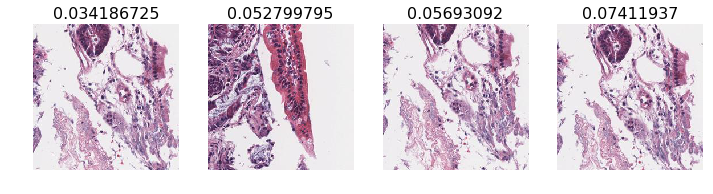

In [21]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

Most Incorrect Normal


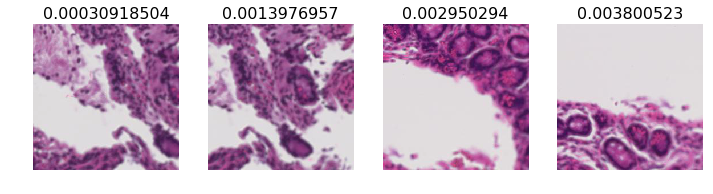

In [22]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [23]:
preds = np.argmax(log_preds, axis=1)

In [25]:
y = data.val_y

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[12172    32  2530]
 [   23 51726    35]
 [ 5431    89 10368]]


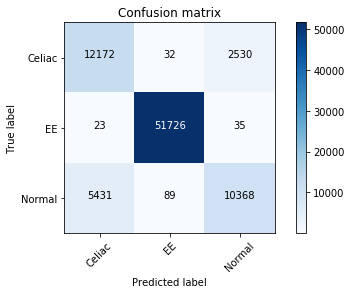

In [27]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [48]:
lrf=learn.lr_find()

 80%|███████▉  | 3446/4324 [00:52<00:14, 60.07it/s, loss=1.25] 

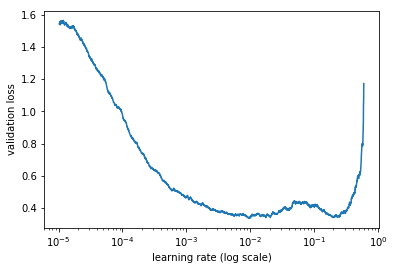

In [49]:
learn.sched.plot()

## Data Augmentation

In [10]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

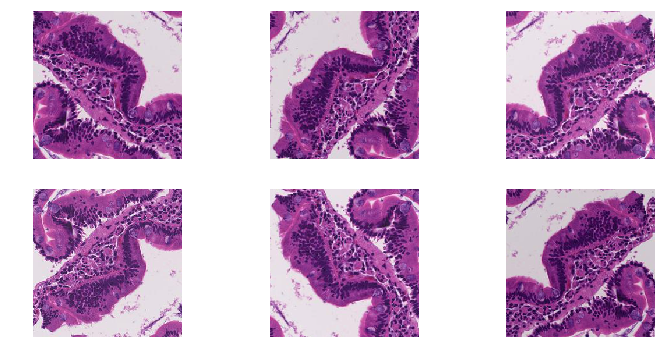

In [52]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [11]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [57]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                        
    0      0.369319   0.260769   0.874803  
    1      0.339573   0.24387    0.880494                       
    2      0.322922   0.239951   0.883783                       


[array([0.23995]), 0.8837827342654757]

In [60]:
learn.save('256_lastlayer')

In [12]:
learn.load('256_lastlayer')

## Unfreezing layers and using Differential learning rates

In [13]:
# Unfreeze all layers for training
learn.unfreeze()

In [31]:
lrf=learn.lr_find()

 72%|███████▏  | 3110/4324 [1:21:45<30:49,  1.52s/it, loss=0.721]  

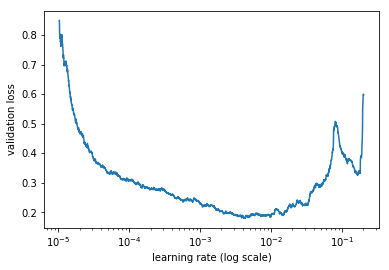

In [32]:
learn.sched.plot()

In [14]:
lr = (1e-4 + 1e-3)/2

In [15]:
lr=np.array([lr/9,lr/3,lr])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

 59%|█████▉    | 2553/4324 [1:08:08<50:50,  1.72s/it, loss=0.229]  

In [ ]:
learn.save('256_all')
learn.load('256_all')

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [ ]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
probs

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
imrnt('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

In [ ]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

In [ ]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [ ]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)